# Alternative Models

In [2]:
library("rjags")

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [7]:
library(car)
library(coda)

In [6]:
data(Leinhardt)

In [8]:
Leinhardt$loginfant = log(Leinhardt$infant)
Leinhardt$logincome = log(Leinhardt$income)

In [9]:
dat = na.omit(Leinhardt)

## 1.  Adding More Features

In [26]:
mod2_string = "model{
    
    for (i in 1:length(y)){
        
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = beta[1] + beta[2]*log_income[i] + beta[3]*is_oil[i]
        
    }

    
    #Priors
    
    for (j in 1:3){
        
        beta[j] ~ dnorm(0.0, 1 / 1e6) #High variance as we are initially uncertain about
                                      #mean
        
    }
    
    prec ~ dgamma(5/2, 5*10/2)
    
    sig = 1/sqrt(prec)
    
}"

In [27]:
set.seed(420)

In [28]:
data2_jags = list(y = dat$loginfant, log_income = dat$logincome, is_oil = as.numeric(dat$oil == "yes"))

In [29]:
mod_params = c("beta", "sig")

In [30]:
init_params = function(){
    
    #For Priors
    inits = list("beta" = rnorm(3,0,100), "prec" = rgamma(1,1,1))
    
}

In [31]:
model2 = jags.model(file = textConnection(mod2_string), data = data2_jags,
                    inits = init_params, n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 4
   Total graph size: 507

Initializing model



### Convergence Diagnostics

In [32]:
update(model2, 1000)

In [33]:
model2_sim = coda.samples(model = model2, variable.names = mod_params, n.iter = 5000)

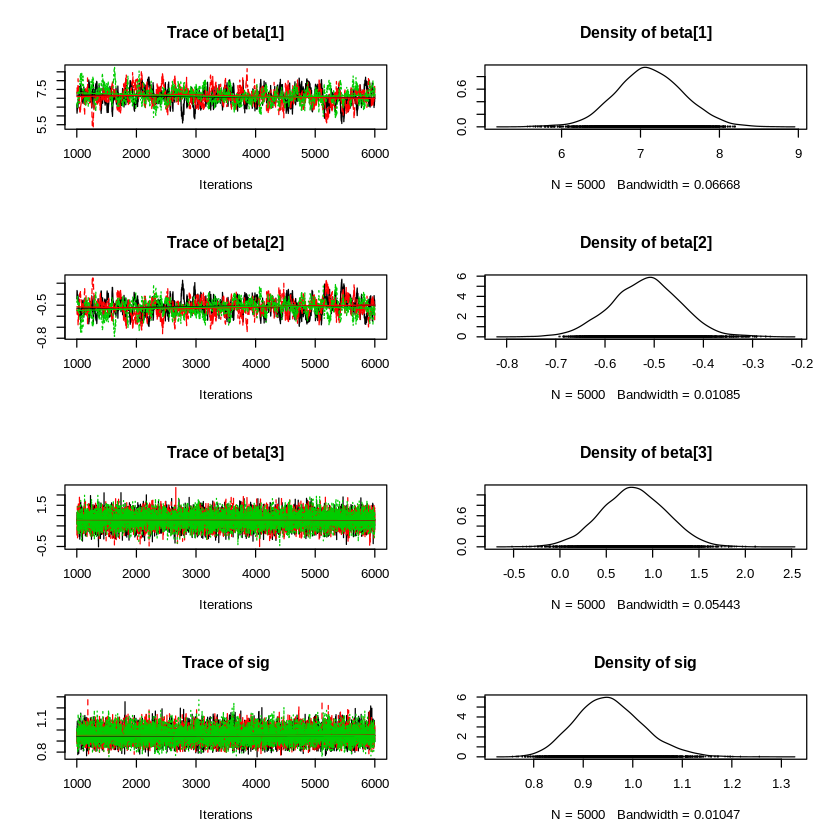

In [34]:
plot(model2_sim)

Seems like it did converge

In [35]:
gelman.diag(model2_sim)

Potential scale reduction factors:

        Point est. Upper C.I.
beta[1]          1       1.01
beta[2]          1       1.01
beta[3]          1       1.00
sig              1       1.00

Multivariate psrf

1

In [36]:
summary(model2_sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD  Naive SE Time-series SE
beta[1]  7.1165 0.43666 0.0035653      0.0231477
beta[2] -0.5175 0.07090 0.0005789      0.0037477
beta[3]  0.7945 0.35136 0.0028688      0.0031022
sig      0.9531 0.06789 0.0005543      0.0005653

2. Quantiles for each variable:

           2.5%     25%     50%     75%   97.5%
beta[1]  6.2700  6.8286  7.1081  7.4053  7.9814
beta[2] -0.6574 -0.5644 -0.5160 -0.4706 -0.3802
beta[3]  0.0989  0.5554  0.7919  1.0329  1.4809
sig      0.8314  0.9057  0.9496  0.9962  1.0984


Note the value of beta[3], it is positively correlated to infant mortality.

Also note that it doesn't mean that oil production causes infant mortality to increase,
we can only say they are positively correlated.

### Residual Analysis

only on Posterior Means

In [42]:
X2 = cbind( rep(1.0, nrow(dat)), data2_jags$log_income, data2_jags$is_oil)

In [44]:
model2_csim = do.call(what = rbind, model2_sim)

In [47]:
mean_param = colMeans(model2_csim)
mean_param

beta[1]    beta[2]    beta[3]        sig 
 7.1165135 -0.5174801  0.7945400  0.9531121

In [49]:
y_pred_mod2 = drop(X2 %*% mean_param[1:3])

In [51]:
residuals2 = data2_jags$y - y_pred_mod2

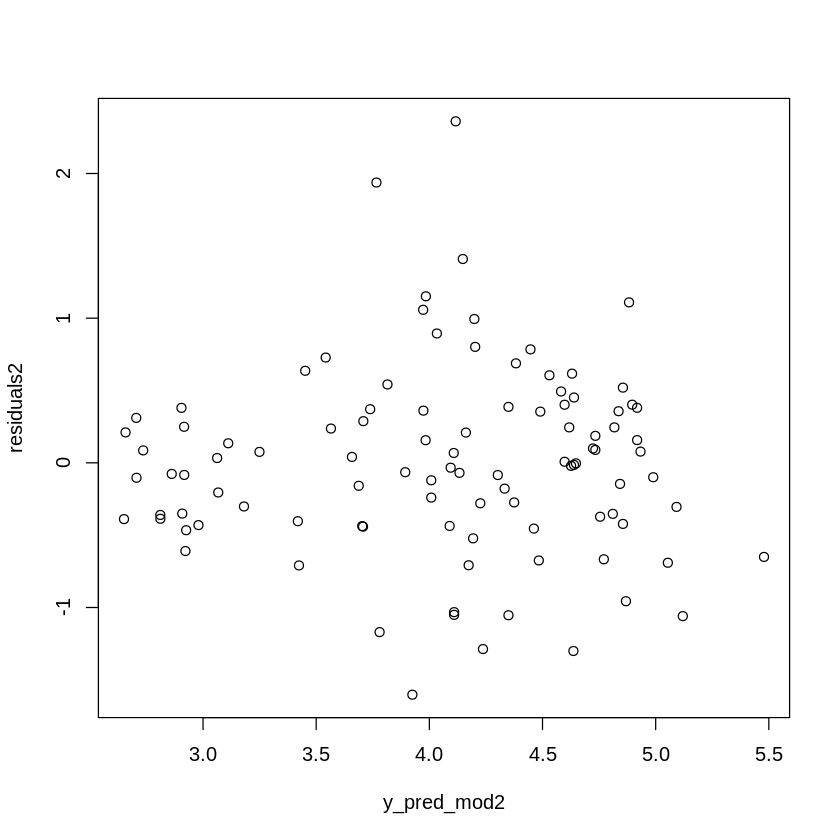

In [52]:
plot(y_pred_mod2, residuals2)


In [54]:
summary(model2_csim)

    beta[1]         beta[2]           beta[3]             sig        
 Min.   :5.380   Min.   :-0.7873   Min.   :-0.5171   Min.   :0.7571  
 1st Qu.:6.829   1st Qu.:-0.5644   1st Qu.: 0.5554   1st Qu.:0.9057  
 Median :7.108   Median :-0.5160   Median : 0.7919   Median :0.9496  
 Mean   :7.117   Mean   :-0.5175   Mean   : 0.7945   Mean   :0.9531  
 3rd Qu.:7.405   3rd Qu.:-0.4706   3rd Qu.: 1.0329   3rd Qu.:0.9962  
 Max.   :8.755   Max.   :-0.2467   Max.   : 2.3705   Max.   :1.2957  

In [55]:
sd(residuals2)

[1] 0.6488897

**Note that the strongest outlier is still > 3 SDs away (3 * 0.6488) which is quite a lot.**

**Thus even though our model has improved, the problem of outliers still persists**

## 2. Changing Likelihood Distribution

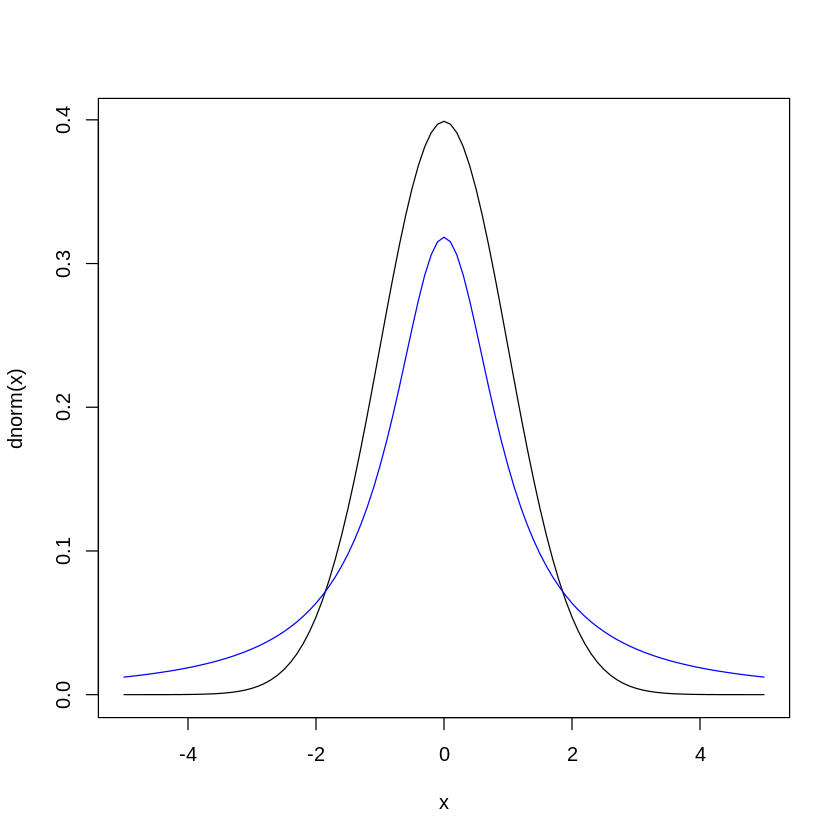

In [62]:
curve(dnorm(x), from = -5, to = 5)
curve(dt(x, df = 1), from = -5, to = 5, add = TRUE, col = "blue")


As visible, the Normal distribution has a much stronger peak and very thin tails, thus it is greatly affected by outliers.

Whereas, the $t$ distribution has a moderate peak but a relativley thicker peak, which acts better for accomodating outliers. 

In [81]:
mod3_string = "model{
    
    #Likelihood
    for (i in 1:length(y)){
        
        y[i] ~ dt(mu[i], tau, df)
        mu[i] = beta[1] + beta[2]*log_income[i] + beta[3]*is_oil[i]
        
    }
    
    #Priors
    #For Beta's
    
    for (i in 1:3){
        
        beta[i] ~ dnorm(0, 1/1e6)
        
    }
    
    df = nu + 2
    nu ~ dexp(1)
    
    tau ~ dgamma(5/2 , 5*10/2)
    sig = sqrt(1 / tau * df / (df - 2))
    
    
}"

In [82]:
set.seed(840)

In [83]:
model_params = c("beta", "sig")

In [84]:
data3_jags = list(y = dat$loginfant, log_income = dat$logincome, is_oil = as.numeric(dat$oil == "yes"))

In [85]:
init_params = function(){
    
    inits = list("beta" = rnorm(3,0,100), "tau" = rgamma(1,1,1), "nu" = rgamma(1,1,1))
    
}

In [86]:
model3 = jags.model(file = textConnection(mod3_string), data = data3_jags, inits = init_params, n.chains = 5)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 5
   Total graph size: 512

Initializing model



#### Burn-In

In [87]:
update(model3, 1000)

In [88]:
model3_sim = coda.samples(model = model3, variable.names = model_params, n.iter = 5000)

In [89]:
summary(model3_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 5 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD  Naive SE Time-series SE
beta[1]  7.3040 0.42220 0.0026703       0.019588
beta[2] -0.5474 0.06779 0.0004288       0.003203
beta[3]  0.4888 0.41028 0.0025948       0.003460
sig      1.1757 0.16144 0.0010211       0.001269

2. Quantiles for each variable:

           2.5%     25%     50%     75%   97.5%
beta[1]  6.4385  7.0197  7.3083  7.5953  8.1239
beta[2] -0.6789 -0.5945 -0.5482 -0.5020 -0.4085
beta[3] -0.2910  0.2134  0.4781  0.7583  1.3274
sig      0.9599  1.0735  1.1501  1.2445  1.5334


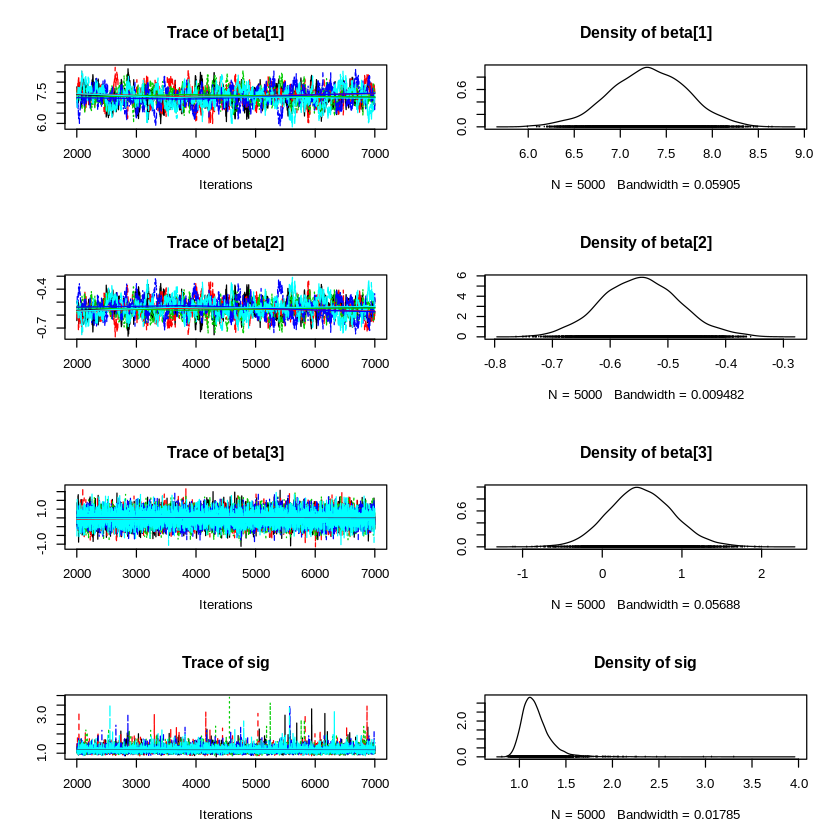

In [90]:
plot(model3_sim)

Seems like it's settled

In [91]:
gelman.diag(model3_sim)

Potential scale reduction factors:

        Point est. Upper C.I.
beta[1]       1.01       1.02
beta[2]       1.01       1.02
beta[3]       1.00       1.00
sig           1.00       1.00

Multivariate psrf

1.01

### Residual Analysis

In [95]:
X3 = cbind( rep(1, nrow(dat)), data3_jags$log_income, data3_jags$is_oil )

In [96]:
head(X3)

1,8.139149,0
1,8.116716,0
1,8.115521,0
1,8.466110,0
1,8.522976,0
1,8.105308,0


In [97]:
model3_csim = do.call(rbind, model3_sim)

In [98]:
head(model3_csim)

beta[1],beta[2],beta[3],sig
7.726823,-0.6423003,0.1328211,1.286344
7.741101,-0.6201036,1.2237850,1.129595
7.777901,-0.6229056,1.3383206,1.033923
7.716319,-0.6228314,0.7864286,1.145933
7.581462,-0.6059877,0.3510771,1.045776
7.580301,-0.5894889,0.8025779,1.447127


In [99]:
mean_params = colMeans(model3_csim)

In [100]:
mean_params

beta[1]    beta[2]    beta[3]        sig 
 7.3039909 -0.5473597  0.4887516  1.1757225

In [101]:
y_pred_mod3 = drop(X3 %*% mean_params[1:3])

In [102]:
residuals3 = data3_jags$y - y_pred_mod3 

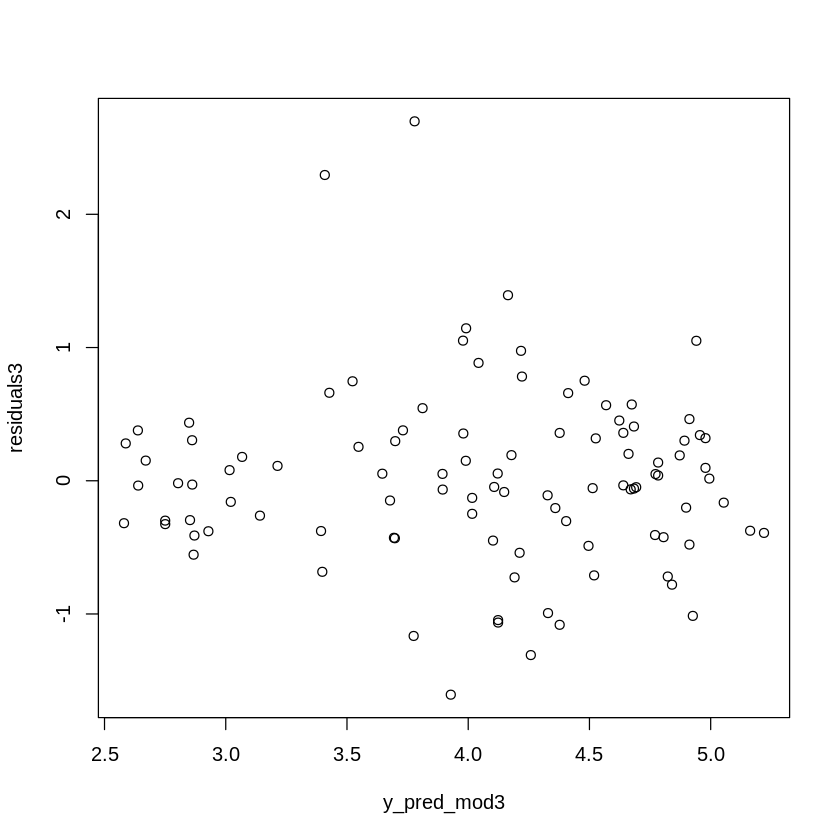

In [103]:
plot(y_pred_mod3, residuals3)


In [104]:
summary(model2_sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD  Naive SE Time-series SE
beta[1]  7.1165 0.43666 0.0035653      0.0231477
beta[2] -0.5175 0.07090 0.0005789      0.0037477
beta[3]  0.7945 0.35136 0.0028688      0.0031022
sig      0.9531 0.06789 0.0005543      0.0005653

2. Quantiles for each variable:

           2.5%     25%     50%     75%   97.5%
beta[1]  6.2700  6.8286  7.1081  7.4053  7.9814
beta[2] -0.6574 -0.5644 -0.5160 -0.4706 -0.3802
beta[3]  0.0989  0.5554  0.7919  1.0329  1.4809
sig      0.8314  0.9057  0.9496  0.9962  1.0984


In [105]:
summary(model3_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 5 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD  Naive SE Time-series SE
beta[1]  7.3040 0.42220 0.0026703       0.019588
beta[2] -0.5474 0.06779 0.0004288       0.003203
beta[3]  0.4888 0.41028 0.0025948       0.003460
sig      1.1757 0.16144 0.0010211       0.001269

2. Quantiles for each variable:

           2.5%     25%     50%     75%   97.5%
beta[1]  6.4385  7.0197  7.3083  7.5953  8.1239
beta[2] -0.6789 -0.5945 -0.5482 -0.5020 -0.4085
beta[3] -0.2910  0.2134  0.4781  0.7583  1.3274
sig      0.9599  1.0735  1.1501  1.2445  1.5334


In [106]:
sd(residuals3)

[1] 0.6552024

**We notice that the outlier problem still persists as it is still > 3 * 0.655. Therefore, changing the Likelihood distribution didn't help at all.**

# Deviance Information Criterion

In [107]:
dic.samples(model2, n.iter = 1000)

Mean deviance:  225.7 
penalty 4.18 
Penalized deviance: 229.9 

In [108]:
dic.samples(model3, n.iter = 1000)

Mean deviance:  231.3 
penalty 4.105 
Penalized deviance: 235.4 

Smaller Mean Deviance implies better likelihood

Higher Penalty implies higher model complexity

Smaller Penalized Deviance implies better Model

**Thus model2 is overall better than model3**